In [9]:
from dotenv import load_dotenv
load_dotenv()

from typing import TypedDict,Annotated
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import  add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import tools_condition,ToolNode
from IPython.display import display,Image
from langgraph.checkpoint.memory import MemorySaver


In [10]:
@tool
def get_stock_price(symbol: str) -> float:
    '''This function returns the stock price
    :param symbol : stock symbol
    :return: current price of stock
    '''

    return{
        "MSFT" :100.6,
        "AAPL" :250.5,
        "GOOG" :175.8,
        "AMZN" :123.0,
    }.get(symbol, 0.00)

tools= [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.5-flash")
llm_with_tools =llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list,add_messages]



def chatbot(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}






E0000 00:00:1759905376.804661   48250 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


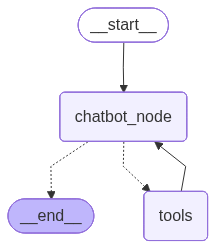

In [11]:
build = StateGraph(State)
build.add_node("chatbot_node", chatbot)
build.add_node("tools",ToolNode(tools))

build.add_edge(START, "chatbot_node")
build.add_conditional_edges( "chatbot_node",tools_condition)
build.add_edge("tools","chatbot_node")

memory = MemorySaver()
app= build.compile(checkpointer=memory)
display(app)

In [12]:
config1 ={"configurable": {"thread_id": "1"}}
message ={"role":"user", "content":"what is the price of AMZN stock price  ?"}
output=app.invoke({"messages" : [message]}, config=config1)
#print(output)
print(output["messages"][-1].content)

{'messages': [HumanMessage(content='what is the price of AMZN stock price  ?', additional_kwargs={}, response_metadata={}, id='beb64018-dc7a-4ec8-bab7-6a8350c8c827'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AMZN"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--5be37e0e-bb67-44ac-83d5-732eedf1c4a0-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AMZN'}, 'id': '511f27b6-790c-454a-9ad4-61eb3154f0e0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 69, 'output_tokens': 98, 'total_tokens': 167, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 80}}), ToolMessage(content='123.0', name='get_stock_price', id='93080c42-7cca-4501-9f9d-957862ae8cec', tool_call_id='511f27b6-790c-454a-9ad4-61eb3154f0e0'), AIMessage(content='The stock price of AMZN is

In [15]:
config2= {"configurable": {"thread_id": "2"}}
message ='add another 10 stock of "GOOG"  to previous total and tell the new total price'
output= app.invoke({"messages" : [{"role":"user", "content":message}]},config=config2)
#print(output)
print(output["messages"][-1].content)

The new total price would be 3804.2


In [19]:
config2= {"configurable": {"thread_id": "2"}}
output=app.invoke({"messages":[{"role":"user", "content":"add another 20 Stock of 'AAPL' to the previous total and tell the new total price"}]},config=config2)
#print(output)
print(output["messages"][ -1].content)


The new total price would be 8814.2
